<a href="https://colab.research.google.com/github/ray-hsiehjy/wine_quality_with_ML/blob/master/wine_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wine Quality* 
- Section 1: Get data and import libraries
- Section 2: Regression with neural network
- Section 3: Regression with ElasticNet and SVR
- Section 4: Comparison and conclusion

    \*Base on physiochemical properties (quality control)


## Data source
- [UCI Machine Learning repositories](https://archive.ics.uci.edu/ml/datasets/Wine+Quality)
- For more information, read [Cortez et al., 2009](http://dx.doi.org/10.1016/j.dss.2009.05.016).

## Input variables (based on physicochemical tests):
- 1 - fixed acidity
- 2 - volatile acidity
- 3 - citric acid
- 4 - residual sugar
- 5 - chlorides
- 6 - free sulfur dioxide
- 7 - total sulfur dioxide
- 8 - density
- 9 - pH
- 10 - sulphates
- 11 - alcohol
    
## Output variable (based on sensory data):
- 12 - quality (score between 0 and 10)


## Questions from first impression
- What are the determinants for wine quality?
- Do reds and whites share the same quality-control metrics? 
- Do different regression approaches generate differential results?

# Section 1: Get data and import libraries

In [1]:
# Get data from UCI repository
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv

--2019-09-20 23:55:27--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84199 (82K) [application/x-httpd-php]
Saving to: ‘winequality-red.csv’

winequality-red.csv 100%[===================>]  82.23K   309KB/s    in 0.3s    

2019-09-20 23:55:28 (309 KB/s) - ‘winequality-red.csv’ saved [84199/84199]

--2019-09-20 23:55:29--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 264426 (258K) [application/x-httpd-php]
Saving to: ‘winequality-white.csv’

winequality-white.c 100%[======

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.preprocessing as preprocessing
from sklearn.linear_model import ElasticNetCV
# from sklearn.metrics import r2_score
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
import tensorflow.keras.backend as K

%matplotlib inline

In [3]:
red_df = pd.read_csv("/content/winequality-red.csv", sep=";")
white_df = pd.read_csv("/content/winequality-white.csv", sep=";")
both_df = pd.concat([red_df, white_df], axis=0, ignore_index=True)

dfs = {"red":red_df, "white":white_df, "both":both_df}

print(f"red:{red_df.shape}, white:{white_df.shape}, both:{both_df.shape}")
dfs["both"].head()

red:(1599, 12), white:(4898, 12), both:(6497, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# Section 2: Regression with Neural Network

## Section 2.1: some util functions

In [0]:
def scale_X(train_X, test_X):
    
    scr = preprocessing.StandardScaler().fit(train_X)
    train_X = scr.transform(train_X)
    test_X = scr.transform(test_X)
    
    return train_X, test_X, scr




def load_split(wine=None, frac=0.9, seed=1):

    """
    wine, either "red" or "white"
    frac, fraction for training, default 0.9
    seed, numpy random seed
    """

    if wine not in ["red", "white", "both"]:
        print("wine type either be 'red' or 'white' or 'both'")
    df = dfs[wine]

    np.random.seed(seed)
    mask = np.random.rand(len(df)) < frac

    train_X = df[mask].iloc[:, :-1].values
    test_X = df[~mask].iloc[:, :-1].values
    train_y = df[mask].iloc[:, -1].values
    test_y = df[~mask].iloc[:, -1].values

    train_y = np.expand_dims(train_y, axis=-1)
    test_y = np.expand_dims(test_y, axis=-1)

    assert train_X.shape[0] == train_y.shape[0]
    assert test_X.shape[0] == test_y.shape[0]
    assert train_X.shape[1] == test_X.shape[1]

    return train_X, train_y, test_X, test_y




def build_model(input_shape, units=64, layers=2, dropout=False):

    """
    input_shape = train_X.shape[1]
    units: neurons in each layer
    layers: number of layers in the middle, integer >= 0
    dropout: True or False, applied to the middle layers
    """

    X_inputs = Input(shape=input_shape)
    
    X = Dense(units, activation="relu")(X_inputs)
    X = BatchNormalization()(X)
    
    for _ in range(layers):
        X = Dense(units, activation="relu")(X)
        X = BatchNormalization()(X)
        if dropout:
            X = Dropout(0.5)(X)

    outputs = Dense(1)(X)

    model = Model(inputs=X_inputs, outputs=outputs)

    return model




def wine_nn(train_wine, units=64, layers=2, dropout=False, cks=None):
    
    """
    train_wine: type of wine for training, either red, white or both
    units: neurons in each layer
    layers: number of layers in the middle, integer >= 0
    dropout: True or False, applied to the middle layers
    """
    
    if train_wine not in ["red", "white", "both"]:
        print ("specify train wine type: 'red', 'white' or 'both'")
    
    train_X, train_y, test_X, test_y = load_split(train_wine)
    train_X, test_X, scr = scale_X(train_X, test_X)
    
    input_shape = train_X.shape[1]
    model = build_model(input_shape, units=units, layers=layers, dropout=dropout)
    
    opt=Adam()
    model.compile(optimizer=opt, loss="mean_squared_error", metrics=["mean_absolute_error"])
    
    history = model.fit(
    train_X, train_y,
    batch_size=64, epochs=1000, 
    verbose=0, callbacks=cks, 
    validation_data=(test_X, test_y))
    
    return history.history, model, scr
    

## Section 2.2: Find a model structure

In [5]:
# grid search for a model structure
%%time

lr_reduction = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, verbose=0, cooldown=10, min_delta=1e-4, min_lr=1e-5)


train_wines = ["red", "white", "both"]
units_lst = [64]    # tried [8, 16, 32, 64, 128, 256]
layers_lst = [2]    # tried [0, 1, 2, 3]
dropout_lst = [True]    # tried [True, False]
cks_lst = [None]    # tried [None, [lr_reduction]] 

histories = {}
for train_wine in train_wines:
    for units in units_lst:
        for layers in layers_lst:
            for dropout in dropout_lst:
                for cks in cks_lst:
                    nn_id = f"{train_wine}_units{units}_layers{layers}_dropout{dropout}_cks{cks != None}"
                    print(nn_id)

                    train_history, _, _ = wine_nn(train_wine, units=units, layers=layers, dropout=dropout, cks=cks)
                    histories[nn_id] = train_history



red_units64_layers2_dropoutTrue_cksFalse
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
white_units64_layers2_dropoutTrue_cksFalse
both_units64_layers2_dropoutTrue_cksFalse
CPU times: user 31min 30s, sys: 3min 9s, total: 34min 39s
Wall time: 23min 41s


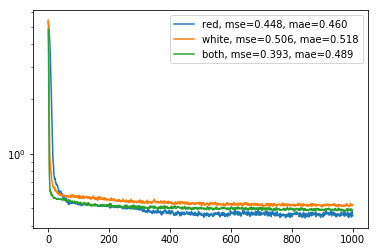

In [6]:
for k, v in histories.items():
    
    last5_val_mse = np.mean(v["val_loss"][-5:])
    last5_val_mae = np.mean(v["val_mean_absolute_error"][-5:])
    
    plt.plot(v["val_mean_absolute_error"], 
             label=f"{k.split('_')[0]}, mse={last5_val_mse:.3f}, mae={last5_val_mae:.3f}")
    plt.legend()
    plt.yscale("log")

## Section 2.3: Create models and cross check performace
- Based on grid search, models will have three 64-units layers followed by single output neuron. Dropout applied to the two middle layers
- The three models are trained with red, white or both respetively
- Individual performance is the same as in section 2.2
- Performace check on other types of wine using cross_pred()

In [0]:
def cross_pred(train_wine, test_wine):
    """
    train_wine: red or white or both
    test_wine: red or white or both
    Note: 
    If train and test are the same. Test will be performed on training set, and yeild good results
    Likewise, training on both will for sure perform good on test_red or test_white
    """
    
    model = models[train_wine]    # models is a dictionary
    scr = scalers[train_wine]    # scalers is a dictionary, values are sklearn scaler object fit with train_wine
    
    test_X = dfs[test_wine].iloc[:, :-1].values    
    test_X = scr.transform(test_X)    # scale test_X with scaler from training data
    test_y = np.expand_dims(dfs[test_wine].iloc[:, -1].values, axis=-1)
    
    print(f"Evaluate {train_wine}_on_{test_wine}")
    mse, _ = model.evaluate(test_X, test_y, batch_size=1, verbose=0)
    
    return mse

In [0]:
models = {}
scalers = {}
for train_wine in ["red", "white", "both"]:
    _, models[train_wine], scalers[train_wine] = wine_nn(train_wine, units=64, layers=2, dropout=True, cks=None)
    

In [0]:
# Red_model perform on red, white, and both

model_comp = pd.DataFrame(
    {
        "red_model":[cross_pred("red", "red"), cross_pred("red", "white"), cross_pred("red", "both")],
        "white_model":[cross_pred("white", "red"), cross_pred("white", "white"), cross_pred("white", "both")],
        "both_model":[cross_pred("both", "red"), cross_pred("both", "white"), cross_pred("both", "both")] 
    }, 
    index=["red", "white", "both"]
)


nn_performance = np.diag(model_comp)

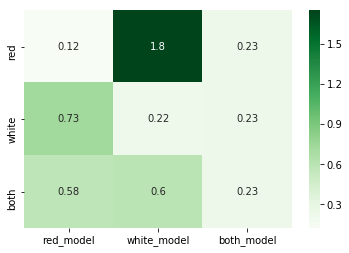

In [18]:
sns.heatmap(model_comp, annot=True, cmap="Greens")

# Section 3: Regression with ElasticNet and SVM

## Section 3.1: Regression with ElasticNet

In [0]:
def elas_regr(train_wine):
    regr = ElasticNetCV(
        l1_ratio = [.1, .5, .7, .9, .95, .99, 1],
        cv = 10,
        random_state=2
    )

    train_X, train_y, test_X, test_y = load_split(train_wine)

    train_X, test_X, _ = scale_X(train_X, test_X)
    train_y = train_y.squeeze()
    test_y = test_y.squeeze()

    regr.fit(train_X, train_y)
    r2 = regr.score(test_X, test_y)

    return regr.mse_path_.min(), regr.coef_, regr, r2

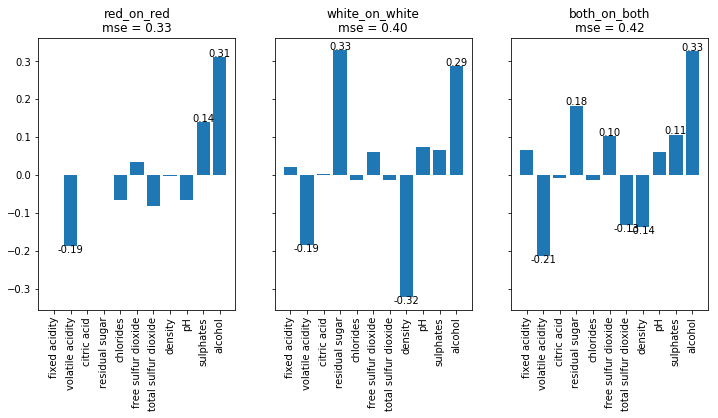

In [13]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5), sharex=True, sharey=True)

elas_performance = []
for train_wine, ax in zip(["red", "white", "both"], axes.flat):
    
    m, c, _, _ = elas_regr(train_wine)
    
    features = dfs[train_wine].columns[:-1]
    ax.bar(features, c)
    ax.set_xticklabels(features, rotation=90)
    ax.set_title(f"{train_wine}_on_{train_wine}\nmse = {m:.2f}")
    
    for i in range(len(features)):
        if abs(c[i]) < 0.1: continue
        if c[i] < 0:
            ax.annotate(s=f"{c[i]:.2f}", xy=(i, c[i]-0.01), ha="center", va="center")
        if c[i] > 0:
            ax.annotate(s=f"{c[i]:.2f}", xy=(i, c[i]+0.01), ha="center", va="center")
        
    
    elas_performance.append(m)


## Section 3.2: Regression with SVR

In [0]:
def svr_regr(train_wine):
    
    features = dfs[train_wine].columns[:-1]
    
    train_X, train_y, test_X, test_y = load_split(train_wine)
    
    train_X, test_X, scr = scale_X(train_X, test_X)
    train_y = train_y.squeeze()
    test_y = test_y.squeeze()

    # little difference between kernel type linear and rbf
    regr = SVR(kernel="rbf", gamma="scale", C=1, cache_size=500)

    regr.fit(train_X, train_y)
    mse = np.square(regr.predict(test_X) - test_y).mean()

    return mse, regr

In [0]:
red_mse, _ = svr_regr("red")
white_mse, _ = svr_regr("white")
both_mse, _ = svr_regr("both")

svr_performance = [red_mse, white_mse, both_mse]

# Section 4: Conclusion

## Section 4.1 Comments on individual models
- neural network perfrom similarly within and across groups
- ElasticNet shows similar performance to neural network
- Further breakdown on feature_weights shows that ElasticNet extract information differently from reds and whites
- SVR performs a little bit worse than the other two, regardless kernel types

## Section 4.2 Compare across models
- In general, nn performs better than ElasticNet or SVR (i.e lower loss, aka mean_squred_error)
- ElasticNet however generates results easier to understand and interpret (i.e the weights on each feature)
- The original paper achieved better results from SVR, perhaps through better tuning. I did not spend too much time optimizing parameters and hyperparameters for all three approaches

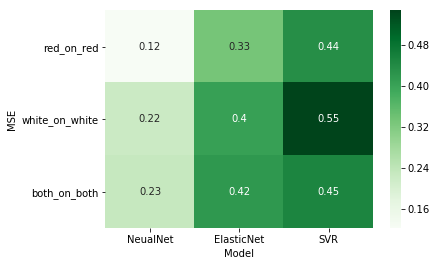

In [17]:
perf_sum = pd.DataFrame(
    {
        "NeualNet": nn_performance,
        "ElasticNet":elas_performance,
        "SVR":svr_performance
    },
    index=["red_on_red", "white_on_white", "both_on_both"]

)

perf_sum.index.name = "MSE"
perf_sum.columns.name = "Model"

sns.heatmap(perf_sum, annot=True, cmap="Greens")